# 4. Autoencoder Generation

In this notebook I'll be creating an autoencoder and generating a representation of the data to be used later on the Feed Forward Neural Network.

In [1]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn.preprocessing as preprocessing
import sklearn.model_selection as model_selection
import fraudutils as futils

Using TensorFlow backend.


In [2]:
# Defining function to show some graphics
def plot_results(p1, p2, legend):
    plt.title(legend)
    plt.plot(p1)
    plt.plot(p2)
    plt.legend([legend, 'Validation ' + legend])
    plt.ylabel(legend)
    plt.xlabel('Epochs')
    plt.show()

In [3]:
# Loading dataset
train, test, val = futils.load_train_test_val_dataset('../../../data/processed/give-me-some-credit/')

X_train = train.drop(['SeriousDlqin2yrs'], axis=1)
y_train = train['SeriousDlqin2yrs']

X_test = test.drop(['SeriousDlqin2yrs'], axis=1)
y_test = test['SeriousDlqin2yrs']

X_val = val.drop(['SeriousDlqin2yrs'], axis=1)
y_val = val['SeriousDlqin2yrs']

### Creating models for representations

In [4]:
n_dims = 3

# Using functional approach
# Defining input layer
inputs = keras.layers.Input(shape=(X_train.shape[1],))

# Defining encoding layers
encoding = keras.layers.Dense(10, activation='relu')(inputs)
encoding = keras.layers.BatchNormalization()(encoding)
encoding = keras.layers.Dense(10, activation='relu')(encoding)
encoding = keras.layers.BatchNormalization()(encoding)
encoding = keras.layers.Dense(n_dims, activation='sigmoid')(encoding)

# Defining decoding/output layer
decoding = keras.layers.BatchNormalization()(encoding)
decoding = keras.layers.Dense(10, activation='sigmoid')(decoding)

# Generating both models
model_trainer = keras.models.Model(inputs=inputs, outputs=decoding)
model_encoder = keras.models.Model(inputs=inputs, outputs=encoding)

model_trainer.compile(optimizer='rmsprop', loss='mse')

Train on 90000 samples, validate on 45000 samples
Epoch 1/10
 - 3s - loss: 0.0990 - val_loss: 0.0115
Epoch 2/10
 - 2s - loss: 0.0032 - val_loss: 0.0010
Epoch 3/10
 - 2s - loss: 5.1491e-04 - val_loss: 4.2188e-04
Epoch 4/10
 - 2s - loss: 3.1950e-04 - val_loss: 4.4472e-04
Epoch 5/10
 - 2s - loss: 1.9382e-04 - val_loss: 5.4448e-04
Epoch 6/10
 - 2s - loss: 1.7243e-04 - val_loss: 5.1520e-04
Epoch 7/10
 - 2s - loss: 1.6248e-04 - val_loss: 4.3353e-04
Epoch 8/10
 - 2s - loss: 1.5540e-04 - val_loss: 4.0634e-04
Epoch 9/10
 - 2s - loss: 1.5046e-04 - val_loss: 3.4322e-04
Epoch 10/10
 - 2s - loss: 1.4350e-04 - val_loss: 1.8889e-04


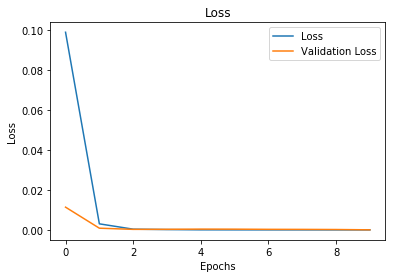

In [5]:
h = model_trainer.fit(X_train, X_train, batch_size=128, epochs=10, validation_data=(X_test, X_test), verbose=2)
plot_results(h.history['loss'], h.history['val_loss'], 'Loss')

### Saving data to csv files to be used later

In [6]:
# Generating representations
X_train_representation = model_encoder.predict(X_train)
X_test_representation = model_encoder.predict(X_test)
X_val_representation = model_encoder.predict(X_val)

In [7]:
# Creating a dataframe for each split
def get_representation(X, y, columns):
    representation = pd.DataFrame(np.column_stack((y, X)), columns=columns)
    return representation

columns = ['SeriousDlqin2yrs']
columns.extend(['f' + str(i) for i in range(n_dims)])

train_representation = get_representation(X_train_representation, y_train, columns)
test_representation = get_representation(X_test_representation, y_test, columns)
val_representation = get_representation(X_val_representation, y_val, columns)

# Saving it to csv
file_path = '../../../data/interim/give-me-some-credit/autoencoder/'

train_representation.to_csv(file_path + 'train_rep.csv')
test_representation.to_csv(file_path + 'test_rep.csv')
val_representation.to_csv(file_path + 'val_rep.csv')